# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 22.19 MiB | 19.14 MiB/s, done.
Resolving deltas: 100% (26319/26319), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # actual architecture below is scaled to match n: [0.5, 0.25, 1024]

backbone:
  - [-1, 1, TorchVision, [464, shufflenet_v2_x1_0, DEFAULT, True, 2, True]] # 0

head:
  - [0, 1, Index, [116, 5]]           # 1: P3
  - [1, 1, ECA, [116]]                # 2
  - [0, 1, Index, [232, 6]]           # 3: P4
  - [3, 1, ECA, [232]]                # 4
  - [0, 1, Index, [464, 7]]           # 5: P5
  - [5, 1, ECA, [464]]                # 6

  # Project to scaled YOLOv11 channel sizes (256 → 64, 512 → 128, 1024 → 256)
  - [2, 1, Conv, [64, 1, 1]]         # 7: P3 → 64
  - [4, 1, Conv, [128, 1, 1]]        # 8: P4 → 128
  - [6, 1, Conv, [256, 1, 1]]        # 9: P5 → 256

  # FPN: P5 → P4
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10
  - [[10, 8], 1, Concat, [1]]                  # 11
  - [-1, 1, C3k2, [128, False]]                # 12 (2 → 1 repeat, 512 → 128)

  # FPN: P4 → P3
  - [12, 1, nn.Upsample, [None, 2, "nearest"]]  # 13
  - [[13, 7], 1, Concat, [1]]                   # 14
  - [-1, 1, C3k2, [64, False]]                  # 15 (256 → 64)

  # PAN: P3 → P4
  - [15, 1, Conv, [64, 3, 2]]                   # 16
  - [[16, 12], 1, Concat, [1]]                  # 17
  - [-1, 1, C3k2, [128, False]]                 # 18

  # PAN: P4 → P5
  - [18, 1, Conv, [128, 3, 2]]                  # 19
  - [[19, 9], 1, Concat, [1]]                   # 20
  - [-1, 1, C3k2, [256, True]]                  # 21

  # Final detection layers
  - [[15, 18, 21], 1, Detect, [nc]]             # 22

  

  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 24, 320, 320])
# 2 torch.Size([1, 24, 320, 320])
# 3 torch.Size([1, 24, 320, 320])
# 4 torch.Size([1, 24, 160, 160])
# 5 torch.Size([1, 116, 80, 80])
# 6 torch.Size([1, 232, 40, 40])
# 7 torch.Size([1, 464, 20, 20])
""")


model = YOLO(model_file, task="detect")

# img = torch.randn(1, 3, 640, 640)
# output = model.model(img)
# for o in output:
#     print(o.shape)

WARNING ⚠️ no model scale passed. Assuming scale='n'.


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:01<00:00, 5.87MB/s]


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=15,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.114 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 155MB/s]
E0000 00:00:1745419412.984808      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745419413.036700      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1    776420  ultralytics.nn.modules.block.TorchVision     ['shufflenet_v2_x1_0', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [5]                           
  2                   1  1         3  ultralytics.nn.modules.conv.ECA              [116]                         
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [6]                           
  4                   3  1         3  ultralytics.nn.modules.conv.ECA              [232]                         
  5                   0  1         0  ultralytics.nn.modules.conv.Index            [7]                           
  6                   5  1         3  ultralytics.nn.modules.conv.ECA              [464]   

100%|██████████| 5.35M/5.35M [00:00<00:00, 283MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:02<00:00, 181.78it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 150.98it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 99 weight(decay=0.0), 109 weight(decay=0.0005), 105 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.69G       3.68      85.53      3.178         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      3.14G      4.436      16.67      3.019         52        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      3.15G      3.986      4.967      1.909         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


                   all        200       1017   0.000902     0.0383   0.000538   0.000131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      3.15G      3.541      3.399      1.433         27        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]


                   all        200       1017      0.261     0.0905     0.0564     0.0114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      3.15G      3.281      2.831      1.298         50        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.411      0.254      0.188     0.0445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      3.15G      3.221      2.605      1.236         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200       1017      0.326       0.26      0.149      0.032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      3.15G      3.188      2.559      1.248         39        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all        200       1017      0.357      0.305      0.214     0.0495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      3.15G      3.009      2.292      1.177         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]

                   all        200       1017      0.333      0.302      0.181      0.038



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      3.15G      3.133      2.321      1.269         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.437      0.307      0.233     0.0537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      3.15G      2.953      2.053      1.218         48        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        200       1017      0.494      0.345      0.291     0.0725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      3.15G      3.011      2.094      1.166         14        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

                   all        200       1017      0.284      0.285      0.135     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      3.15G      2.994      2.149      1.185         18        640: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        200       1017      0.332      0.284      0.201     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      3.15G      3.035      2.032      1.219         16        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        200       1017      0.433      0.356      0.259     0.0712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      3.15G      2.857      1.872      1.122         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        200       1017      0.353      0.334      0.209     0.0502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      3.15G      2.823      1.805      1.117         37        640: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


                   all        200       1017      0.399      0.343      0.225     0.0574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      3.15G      2.778      1.745      1.117         46        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200       1017       0.48      0.383       0.31     0.0806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      3.15G      2.797      1.675       1.13         38        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200       1017      0.529      0.419      0.347     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      3.15G      2.764      1.647      1.162         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200       1017      0.522       0.39      0.357     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      3.15G      2.726      1.585      1.111         49        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200       1017      0.492      0.398      0.326     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      3.15G        2.7      1.557      1.109         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        200       1017      0.517      0.415      0.367      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      3.15G      2.695      1.573      1.171         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200       1017       0.49      0.378      0.328      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      3.15G      2.685      1.468      1.095         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200       1017      0.491      0.399      0.334     0.0898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      3.15G      2.686      1.452      1.076         21        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        200       1017      0.515      0.389      0.322     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      3.15G       2.67      1.449        1.1         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


                   all        200       1017      0.532      0.402      0.359      0.098

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      3.15G      2.632      1.455      1.083         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200       1017      0.546      0.433      0.367      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      3.15G      2.559      1.375      1.106         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


                   all        200       1017      0.562      0.406      0.368      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      3.15G      2.686      1.407      1.079         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200       1017      0.536       0.39      0.334     0.0895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      3.15G      2.636      1.369      1.101         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200       1017      0.531      0.437      0.385      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      3.15G      2.639      1.356      1.087         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]


                   all        200       1017      0.523      0.427      0.352      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      3.15G      2.574      1.323      1.055         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]


                   all        200       1017      0.523      0.396      0.361      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      3.15G      2.576      1.326      1.141         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200       1017      0.523      0.427      0.365      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      3.15G      2.566      1.314      1.086         42        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200       1017      0.496       0.34      0.286     0.0765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      3.15G      2.776      1.396      1.132         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        200       1017      0.539      0.422       0.38      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      3.15G      2.472      1.255      1.055         37        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

                   all        200       1017      0.547      0.393      0.359      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      3.15G      2.553      1.254      1.078         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        200       1017      0.603      0.431      0.433      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      3.15G      2.552       1.25      1.042         32        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200       1017      0.546      0.416      0.373      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      3.15G       2.53      1.272      1.065         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200       1017      0.484      0.359      0.331     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      3.15G       2.54      1.245      1.057         41        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        200       1017      0.503      0.383      0.344     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      3.15G      2.521      1.239      1.058         25        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        200       1017      0.604      0.434      0.412      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      3.15G      2.447      1.201      1.078         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


                   all        200       1017      0.509      0.421      0.393       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      3.15G      2.446      1.187      1.063         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200       1017       0.56      0.432      0.422      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      3.15G      2.415       1.17      1.092         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200       1017      0.586      0.441      0.409      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      3.15G      2.488      1.188      1.038         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

                   all        200       1017      0.504      0.413      0.395      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      3.15G      2.468      1.189      1.106         32        640: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200       1017      0.546       0.45      0.424      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      3.15G      2.441      1.183      1.027         41        640: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        200       1017      0.548      0.427      0.417      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      3.15G      2.418       1.16      1.037         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200       1017      0.553       0.43      0.429      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      3.15G      2.401      1.122      1.035         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        200       1017       0.59      0.473      0.452      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      3.15G      2.416      1.122      1.006         40        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200       1017      0.587      0.427      0.428      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      3.15G      2.398      1.139      1.048         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200       1017      0.564       0.46      0.452      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      3.15G      2.421       1.15      1.036         56        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        200       1017      0.577      0.441      0.424      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      3.15G      2.412      1.113      1.036         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        200       1017      0.556      0.434      0.419      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      3.15G      2.397      1.118      1.032         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200       1017      0.559      0.425      0.407      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      3.15G      2.383      1.101      1.015         57        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200       1017      0.596      0.473      0.464      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      3.15G      2.319      1.088      1.044         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        200       1017      0.597      0.466      0.427      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      3.15G      2.356      1.116      1.082         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200       1017      0.618      0.436      0.432      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      3.15G      2.419      1.116      1.023         44        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        200       1017      0.583      0.461      0.445      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      3.15G      2.349      1.103      1.011         11        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200       1017      0.601      0.441      0.418      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      3.15G      2.375      1.087      1.045         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]

                   all        200       1017      0.597      0.473      0.469      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      3.15G      2.302      1.061      1.041         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200       1017      0.548      0.444      0.431      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      3.15G        2.3      1.086      1.043         51        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

                   all        200       1017      0.569      0.453      0.435      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      3.15G      2.318      1.075     0.9965         43        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200       1017      0.604      0.434      0.433      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      3.15G       2.23      1.051      1.036         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200       1017      0.617      0.454      0.464      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      3.15G      2.327      1.065     0.9999         45        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        200       1017      0.632      0.468      0.472      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      3.15G      2.301      1.055      1.019         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200       1017      0.607      0.439      0.422      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      3.15G      2.236      1.056      1.018         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        200       1017       0.59      0.441      0.425       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      3.15G      2.233       1.04     0.9961         29        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200       1017      0.617      0.444      0.445       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      3.15G      2.258      1.048      1.012         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        200       1017      0.585      0.471      0.454      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      3.15G      2.266      1.032      1.022         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        200       1017      0.606      0.463      0.462       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      3.15G      2.282      1.073      1.017         13        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        200       1017        0.6      0.441      0.451      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      3.15G      2.245      1.068     0.9826         23        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


                   all        200       1017      0.629      0.462      0.463      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      3.15G      2.282      1.052       1.01         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        200       1017       0.64      0.462      0.474      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      3.15G       2.23     0.9975      1.025         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


                   all        200       1017      0.644      0.485      0.495      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      3.15G        2.3      1.036      1.012         46        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200       1017      0.608      0.446      0.467      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      3.15G      2.161     0.9908       1.03         44        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]

                   all        200       1017        0.6      0.461      0.471      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      3.15G      2.262      1.007      1.002         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200       1017      0.572      0.466      0.465      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      3.15G      2.254      1.015      1.008         45        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200       1017      0.566      0.436      0.447      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      3.15G       2.19     0.9856     0.9966         19        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        200       1017      0.561       0.46       0.45      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      3.15G      2.214       1.02      1.054         33        640: 100%|██████████| 32/32 [00:14<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

                   all        200       1017        0.6      0.471      0.474      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      3.15G      2.196      1.003      1.024         31        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        200       1017      0.612      0.465       0.49       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      3.15G      2.254      1.013     0.9877         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200       1017      0.633       0.47      0.504      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      3.15G      2.185     0.9997      1.017         25        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        200       1017      0.644      0.437      0.474      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      3.15G      2.167     0.9915     0.9981         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

                   all        200       1017      0.632      0.467      0.467      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      3.15G      2.204      1.032     0.9829         40        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all        200       1017      0.621      0.476      0.481      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      3.15G      2.186     0.9866     0.9961         48        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all        200       1017      0.572      0.442       0.45      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      3.15G      2.209      1.022     0.9991         56        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200       1017      0.596      0.489      0.481      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      3.15G      2.148     0.9685     0.9912         43        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200       1017        0.6      0.475      0.473      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      3.15G      2.128     0.9562     0.9931         41        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        200       1017       0.61      0.482      0.493      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      3.15G      2.154     0.9932     0.9955         22        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200       1017      0.582      0.447      0.464       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      3.15G      2.173      1.002      1.008         60        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        200       1017      0.594      0.449      0.458      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      3.15G        2.1     0.9426     0.9781         53        640: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]

                   all        200       1017      0.644      0.482      0.484      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      3.15G      2.195     0.9694     0.9673         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200       1017      0.623       0.48       0.49      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      3.15G      2.113     0.9558     0.9737         41        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        200       1017      0.617      0.465      0.463      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      3.15G       2.11     0.9615     0.9456         48        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200       1017      0.607      0.492      0.485      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      3.15G      2.088      0.928     0.9769         42        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.84it/s]

                   all        200       1017      0.649      0.441      0.479      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      3.15G      2.114     0.9492     0.9762         16        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200       1017      0.687      0.471      0.501      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      3.15G      2.122     0.9511     0.9707         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]

                   all        200       1017      0.648      0.485      0.504      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      3.15G      2.013     0.9172      0.969         17        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        200       1017      0.645      0.493      0.496      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      3.15G      2.053     0.9287     0.9717         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        200       1017      0.651       0.49      0.517      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      3.15G      2.031     0.9366     0.9904         22        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200       1017      0.656      0.491       0.51      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      3.15G      2.037     0.9819     0.9546         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        200       1017      0.655      0.523       0.53      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      3.15G      2.031     0.9354     0.9658         18        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200       1017       0.61      0.512      0.508      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      3.15G      2.113     0.9318     0.9619         34        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        200       1017      0.647      0.505      0.513      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      3.15G      2.027      0.908     0.9532         22        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200       1017      0.626      0.492      0.488      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      3.15G      2.063     0.9114      0.967         46        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all        200       1017      0.638      0.498      0.512      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      3.15G      2.105     0.9567     0.9593         54        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.621      0.497      0.511      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      3.15G      2.077     0.9594     0.9673         35        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]

                   all        200       1017      0.653       0.52      0.518       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      3.15G      2.011     0.9005     0.9727         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

                   all        200       1017      0.671      0.489      0.505       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      3.15G      1.975       0.88     0.9853         15        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.621      0.474      0.493      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      3.15G       2.03     0.9103     0.9551         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200       1017      0.588      0.459      0.456      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      3.15G      2.051     0.9267     0.9684         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200       1017      0.601      0.489      0.491      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      3.15G      2.094     0.9197     0.9677         26        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

                   all        200       1017       0.63      0.486      0.486      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      3.15G      2.024     0.8962     0.9485         17        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200       1017      0.615      0.501      0.503      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      3.15G      1.994     0.9119     0.9773         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        200       1017      0.637      0.482      0.501      0.171


EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 98, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

113 epochs completed in 0.497 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 4.7MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 4.7MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 230 layers, 2,149,744 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


                   all        200       1017      0.651      0.491      0.518      0.178


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8ab60638d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 6 humans, 55.8ms
Speed: 3.3ms preprocess, 55.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


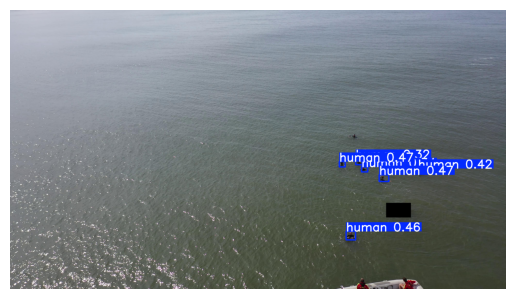

Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 230 layers, 2,149,744 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 158.06it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


                   all        200       1072      0.683      0.571      0.566      0.201


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.0ms preprocess, 4.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8a9f5e2350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

model.val(
    data=data_file,
    split="test"
)